**QUESTION 4**

In [ ]:
# Downloading the nature_12K image dataset from the this URL and save it as 'nature_12K.zip'
!wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip -O nature_12K.zip
!unzip -q nature_12K.zip
#Remove the zip file after extraction to free up disk space
!rm nature_12K.zip

--2025-04-18 17:10:13--  https://storage.googleapis.com/wandb_datasets/nature_12K.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3816687935 (3.6G) [application/zip]
Saving to: ‘nature_12K.zip’

nature_12K.zip      100%[===================>]   3.55G   154MB/s    in 28s     

2025-04-18 17:10:42 (129 MB/s) - ‘nature_12K.zip’ saved [3816687935/3816687935]



In [ ]:
#importing the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Loader for Test Set
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

#--------------------------
#UNSEEN VAL DATA TAKEN AS TEST DATA
#----------------------------
test_data = datasets.ImageFolder('inaturalist_12K/val', transform=test_transform)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
class_names = test_data.classes

# Best Model
class BestModel(nn.Module):
    def __init__(self, num_classes=10):
        super(BestModel, self).__init__()
        f = 64  # initial filters
        k = 5   # kernel size
        p = 2   # padding = (k - 1) // 2

        self.features = nn.Sequential(
            nn.Conv2d(3, f, k, padding=p),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(f, f*2, k, padding=p),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(f*2, f*4, k, padding=p),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(f*4, f*8, k, padding=p),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(f*8, f*16, k, padding=p),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.flattened_size = f*16 * 7 * 7
        self.fc1 = nn.Linear(self.flattened_size, 1024)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        return self.out(x)

# Initialize and load to device
model = BestModel(num_classes=10).to(device)


# Optimizer Setup (RMSprop)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Evaluation on Test Set
model.eval()
correct = 0
total = 0
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy:40.3%


 10×3  grid containing sample images from the test data and predictions made by the best model

FileUpload(value={}, accept='image/*', description='Upload')

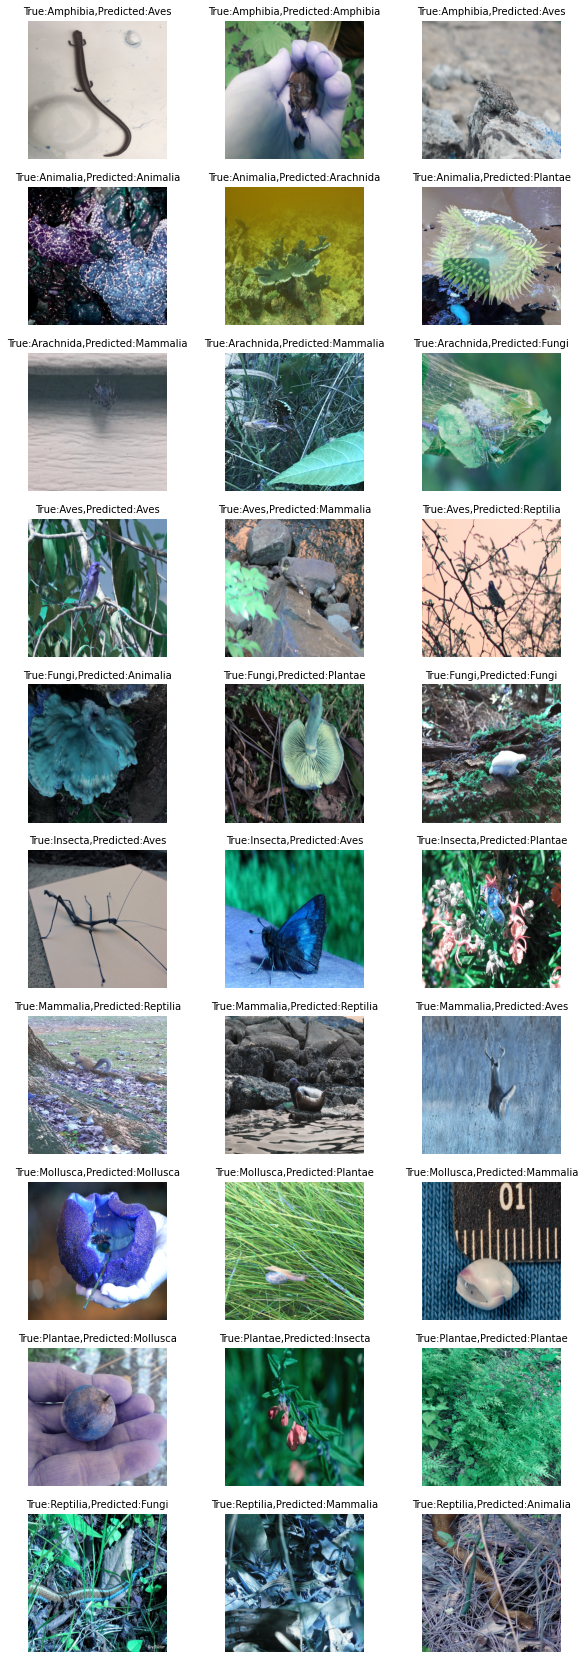

In [ ]:
def show_prediction_grid(images, true_labels, pred_labels):
    fig, axes = plt.subplots(10, 3, figsize=(12, 25))
    for i in range(10):
        for j in range(3):
            idx = i * 3 + j
            img = (images[idx] * 0.229 + 0.485).clip(0, 1)  # unnormalize
            axes[i][j].imshow(img)
            axes[i][j].set_title(f"T: {class_names[true_labels[idx]]}\nP: {class_names[pred_labels[idx]]}",
                                 fontsize=8)
            axes[i][j].axis("off")
    plt.suptitle("10×3 Prediction Grid", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

show_prediction_grid(X_batch, Y_true, Y_pred)

OPTIONAL PARTC

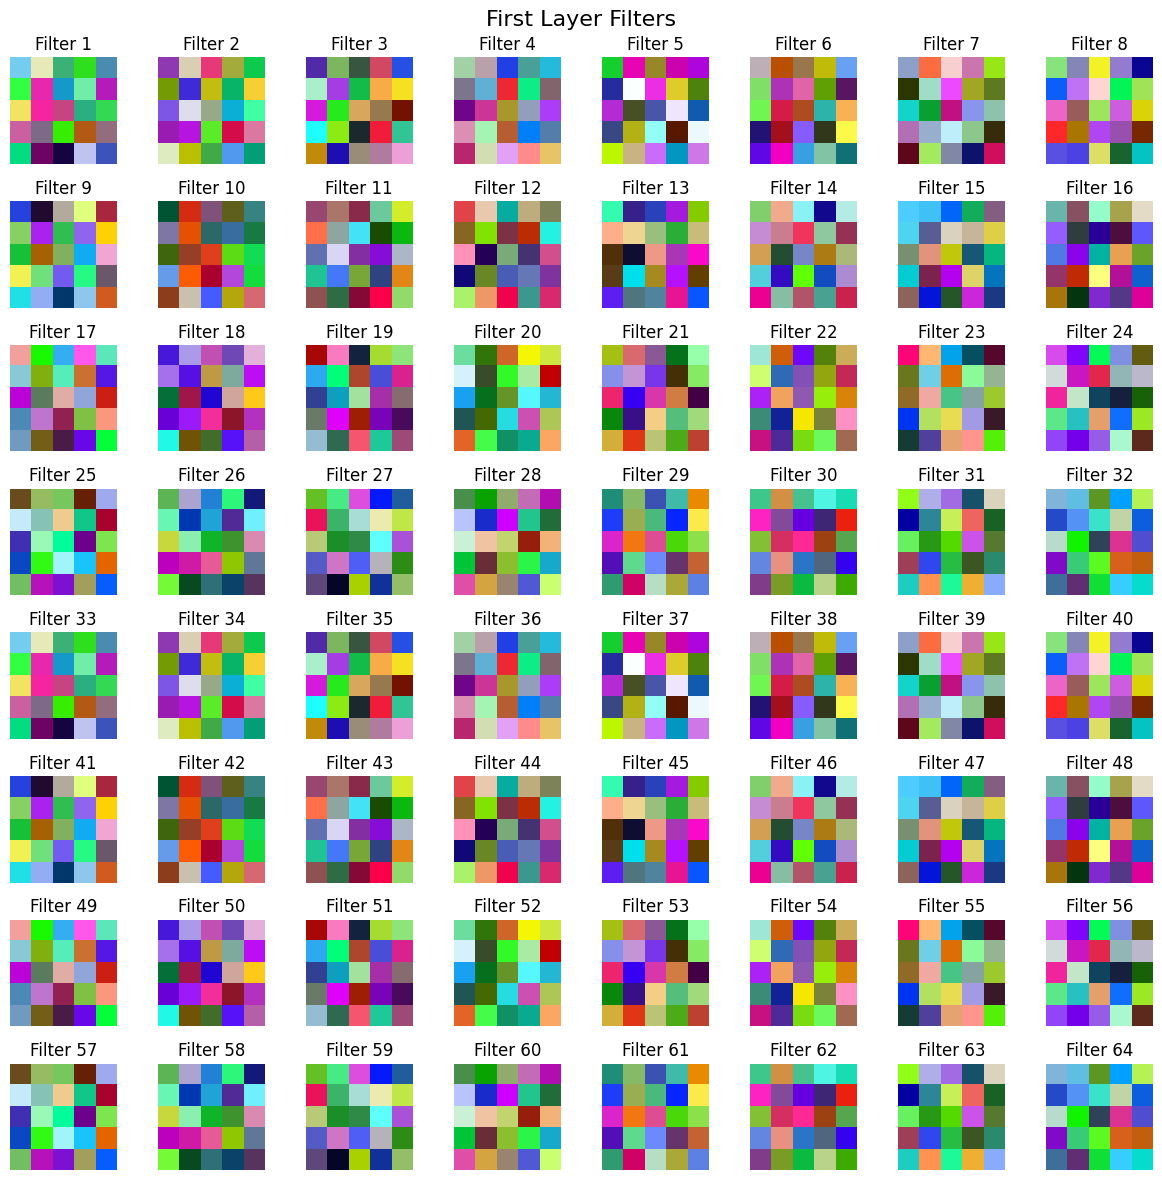

In [ ]:
first_layer = model.features[0]
filters = first_layer.weight.data.clone().cpu()

fig, axes = plt.subplots(8, 8, figsize=(12, 12))
for i in range(64):
    f = filters[i % 32]  # wrap around if <64 filters
    f_img = f.permute(1, 2, 0).numpy()
    f_img = (f_img - f_img.min()) / (f_img.max() - f_img.min())
    axes[i // 8][i % 8].imshow(f_img)
    axes[i // 8][i % 8].axis("off")
    axes[i // 8][i % 8].set_title(f"Filter {i+1}")
plt.suptitle("First Layer Filters", fontsize=16)
plt.tight_layout()
plt.show()